In [1]:
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import helpers
from helpers import fb,pb,TeV,GeV,m,MeV,mm,fm
import matplotlib as mpl
from collections import OrderedDict
import math

## Get HSCP efficiencies

In [2]:
#Get exclusion curve for 8 TeV (tracker)
M1dataFile = '../smodels-database/8TeV/CMS/CMS-EXO-13-006-eff/orig/eff_HSCPM1_c300.txt'
M2dataFile = '../smodels-database/8TeV/CMS/CMS-EXO-13-006-eff/orig/eff_HSCPM2_c300.txt'
e12Func = helpers.getUpperLimitFrom(M1dataFile,xcol=0,ycol=1,unit=1.,doLog=False)
e1Func = helpers.getUpperLimitFrom(M2dataFile,xcol=0,ycol=1,unit=1.,doLog=False)

## Get SLHA and fLLP data

In [3]:
slhaFiles = [f for f in glob.glob('./slha_zeroWidth/*leptons.slha')]
fractionFiles = [f for f in glob.glob('./LLPfraction_8TeV/*leptons.txt')]
massPDG = widthPDG = 5000011
xsecPDGs = (2212, 2212, -5000011, 5000011)
xsecSqrts = 8*TeV
Ldetector = 3.*m
upperLimitFunction = lambda x: 1.*fb
slhaData = helpers.getData(slhaFiles,massPDG,widthPDG,xsecSqrts,xsecPDGs,upperLimitFunction)
for slhafile in slhaData:
    res = slhaData[slhafile]
    mass = res['mass (GeV)']
    e12 = e12Func(mass)
    e1 = e1Func(mass)
    slhaData[slhafile].update({'e12' : e12, 'e1' : e1})
fractionData = helpers.getLLPFractionData(fractionFiles,xcol=0,ycol=1)

In [4]:
#SModelS expr:
# sigma_eff = (e12*Flong**2 + 2*Flong*Fprompt*e1)*sigma
#Full expr:
# sigma_eff = e12*fLLP*sigma
#Solving for Flong:
#Flong = math.sqrt( (e1*Fprompt/e12)**2  + fLLP) - e1*Fprompt/e12

#        
#        Fprompt = 1. - math.exp(-width*l_inner/(gb_inner*hc))
#        Flong = math.exp(-width*l_outer/(gb_outer*hc))
#        gb_outer = -l_outer/(ctau*math.log(Flong))

l_inner=1e-3*m
gb_inner=1.3
l_outer=10.*m
gb_outer=1.3
points = []
for slhafile in slhaData:
    res = slhaData[slhafile]
    fLLP = fractionData[slhafile]
    e12 = res['e12']
    e1 = res['e1']
    if not e12 or not e1:
        continue
    ctau = l_outer.asNumber(m)/fLLP[:,0]
    Fprompt = 1. - np.exp(-l_inner.asNumber(m)/(gb_inner*ctau))
    Flong = np.sqrt((e1*Fprompt/e12)**2  + fLLP[:,1]) - e1*Fprompt/e12
    gb_outer = -l_outer.asNumber(m)/(ctau*np.log(Flong))    
    mList = [res['mass (GeV)']]*len(ctau)   
    points += zip(mList,ctau,gb_outer,fLLP[:,1],Flong)
points = np.array(points)

## Plot Results

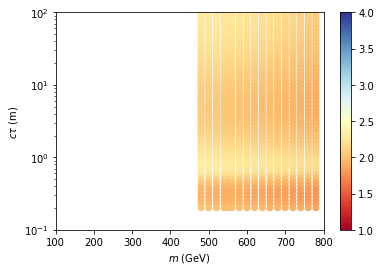

In [5]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=points[:,2], vmin=1, vmax=4, s=35, cmap=cm)
plt.colorbar(sc)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
plt.ylim(1e-1,1e2)
plt.xlim(100.,800.)
plt.show()

In [6]:
print(max([x for x in points[:,2] if not np.isnan(x)]))
print(min([x for x in points[:,2] if not np.isnan(x)]))

2.3575707002490476
1.786260535274095


In [7]:
i = 190
print(points[i])
print('width=',1.967e-16/points[i,1])

[6.20000000e+02 5.67772441e-01 2.16848259e+00 5.43526000e-07
 2.96896629e-04]
('width=', 3.464416123e-16)


In [8]:
print(e1Func(620.))
print(e12Func(620.))

0.324
0.572
